In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime

In [2]:
ANOS_PASSADOS=2

In [3]:
def parse_bcb(codigo_serie, indice):
    # Obtendo a data atual
    hoje = datetime.now()
    
    # Calculando as datas de início e fim
    data_inicio = f"{hoje.day}/{hoje.month}/{hoje.year-ANOS_PASSADOS}"
    data_final = f"{hoje.day}/{hoje.month}/{hoje.year}"

    # Construindo a URL para a API
    URL = f"https://api.bcb.gov.br/dados/serie/bcdata.sgs.{codigo_serie}/dados?formato=csv&dataInicial={data_inicio}&dataFinal={data_final}"
    #print(URL)
    # Lendo o CSV do link fornecido
    df = pd.read_csv(URL, sep=";")

    # Convertendo a coluna "data" para o formato datetime
    # Aqui, ajustei o formato da data para corresponder ao formato fornecido: %d/%m/%Y
    df.rename(columns={"data": "date"}, inplace=True)
    df["date"] = pd.to_datetime(df["date"], format='%d/%m/%Y')
    df.set_index('date', inplace=True)
    df["valor"] = df["valor"].str.replace(',', '.').astype(float)
    df.rename(columns={"valor": indice}, inplace=True)
    return df


In [4]:
selic_df=parse_bcb(11, "Selic")
ipca_df=parse_bcb(10844, "IPCA")

In [5]:
indices=["^BVSP", "DIVO11.SA"]
tickers=["WEGE3", "MGLU3", "VALE3", "GGBR4"]
tickers=[t+ ".SA" for t in tickers ]
tickers=[t.upper() for t in tickers+indices]
tickers

['WEGE3.SA', 'MGLU3.SA', 'VALE3.SA', 'GGBR4.SA', '^BVSP', 'DIVO11.SA']

In [6]:

hoje = datetime.now()
start_date=f"{hoje.year-ANOS_PASSADOS}-{datetime.now().month}-{datetime.now().day}"
ativos= yf.download(tickers, start_date)['Adj Close']

[*********************100%%**********************]  6 of 6 completed


<Axes: xlabel='Date'>

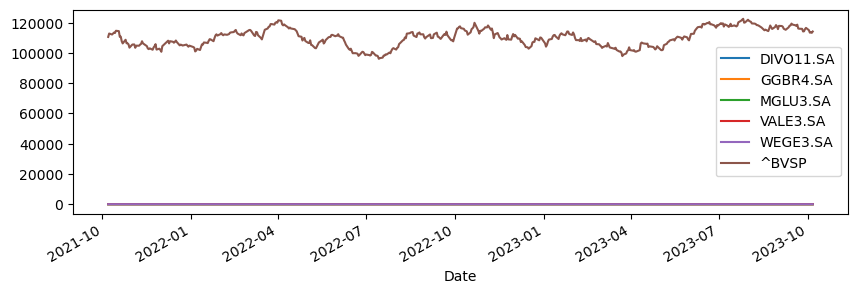

In [7]:
ativos.plot(figsize=(10,3))

### Daily Returns

In [8]:
# daily_returns
def daily_retunrs(df):
    return df.pct_change(1).dropna()

In [9]:
# cumulative returns
def cumulative_return(daily_returns_df):
    cumulative_return = (1 + daily_returns_df).cumprod() - 1
    cumulative_return_pct = cumulative_return*100
    return cumulative_return_pct


In [10]:
cumulative_return_pct = cumulative_return(daily_retunrs(ativos))


Text(0, 0.5, 'Cumulative Return as %')

<Figure size 960x720 with 0 Axes>

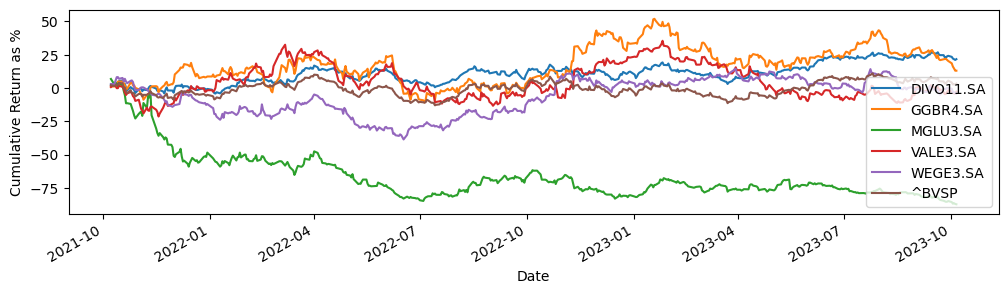

In [11]:
plt.figure(dpi=150)
cumulative_return_pct.plot(figsize=(12,3))
plt.ylabel("Cumulative Return as %")

In [12]:
def risk_free_rate(selic, ipca):
    ipca_mean = ipca.mean().values[0]*12
    selic_mean = selic.mean().values[0]*22*12
    print("IPCA:", ipca_mean/100, "SELIC:",selic_mean/100 )
    if ipca_mean > selic_mean:
        return ipca_mean/100
    return selic_mean/100
    
r_free_rate = risk_free_rate(selic_df, ipca_df)
r_free_rate

IPCA: 0.06834782608695651 SELIC: 0.12137739053677937


0.12137739053677937

In [13]:
def sharpe_ratio(data, r_free_rate = 0):
    daily_return= daily_retunrs(data)
    mean_return = daily_return.mean()
    std = daily_return.std()
    sharpe_ratio = (mean_return-r_free_rate) / std
    return sharpe_ratio 

sharpe_ratio(ativos,r_free_rate)

DIVO11.SA   -10.465149
GGBR4.SA     -5.436702
MGLU3.SA     -2.538930
VALE3.SA     -5.484596
WEGE3.SA     -6.066430
^BVSP        -9.594883
dtype: float64

In [14]:
def sortino_ratio(data, target=0, r_free_rate=0):
    daily_return= daily_retunrs(data)
    mean_return = daily_return.mean()
    downside = daily_return[daily_return < target]
    std = downside.std()
    sortino_ratio = (mean_return-r_free_rate) / std
    return sortino_ratio


In [15]:
sortino_ratio(ativos,0,r_free_rate)

DIVO11.SA   -17.427142
GGBR4.SA     -8.473114
MGLU3.SA     -4.103854
VALE3.SA     -9.627878
WEGE3.SA    -10.758797
^BVSP       -15.300248
dtype: float64

In [16]:
import scipy.stats

In [17]:
def prob_sharpe_ratio(data, benchmark=0):
    
    daily_return= daily_retunrs(data)
    
    sr = sharpe_ratio(data, benchmark)
    
    skew = scipy.stats.skew(daily_return)
    # Use fisher kurtosis
    
    kurtosis = scipy.stats.kurtosis(daily_return, fisher=True)  
    
    n = len(data)
    
    std = ( (1 / (n-1)) * (1 + 0.5 * sr**2 - skew * sr + (kurtosis / 4) * sr**2))**0.5
    
    ratio = (sr - benchmark) / std
    prob_sharpe_ratio = scipy.stats.norm.cdf(ratio)
    return prob_sharpe_ratio

In [18]:
prob_sharpe_ratio(ativos,r_free_rate)

array([3.33049910e-178, 8.34897233e-137, 2.34656458e-123, 6.09323497e-110,
       3.36261137e-107, 1.05415942e-172])

In [25]:
# beta

from scipy.stats import linregress


def beta(data, ticker, benckmark_ticker):
    daily_return= daily_retunrs(ativos)
    beta, alpha, _,_,_ = linregress(daily_return[ticker],daily_return[benckmark_ticker])
    return beta, alpha

In [20]:
beta1, alpha1 = beta(ativos,"WEGE3.SA","DIVO11.SA")

0.20723636852387484 0.0004349763059601284


In [33]:
for t in tickers:
    b, a = beta(ativos,t,"^BVSP")
    print(t)
    print("--------------------------")
    print("beta:", round(b,2),"alpha:", round(a,4))
    print()

WEGE3.SA
--------------------------
beta: 0.29 alpha: 0.0001

MGLU3.SA
--------------------------
beta: 0.14 alpha: 0.0005

VALE3.SA
--------------------------
beta: 0.29 alpha: 0.0001

GGBR4.SA
--------------------------
beta: 0.31 alpha: -0.0

^BVSP
--------------------------
beta: 1.0 alpha: 0.0

DIVO11.SA
--------------------------
beta: 0.96 alpha: -0.0003

